# Quantum Phase Estimation on IBM hardware

Now that you should be properly registered with IBM and able to run programs on their quantum devices, it's time to compute something useful. 

In this notebook we're going to do just that with the Quantum Phase Estimation algorithm, which we saw about three weeks ago. Since we stay in the Qiskit ecosystem, we'll be able to reuse a lot of code we've built before.

As you've seen last week, quantum computers usually suffer from noise. Here we'll be able to compare that directly with our noiseless experience in the original quantum phase estimation notebook.

To motivate you perhaps a bit more, note that such hardware runs are actually quite hard. For example, a somewhat recent [pre-print](https://arxiv.org/abs/2212.12372) (whose conclusions seem to be up for discussion, but that's another matter), ran Shor's algorithm -- whose crucial component is QPE -- on 10 qubits. So in this notebook we're not necessarily going for state-of-the-art results, but still something very much non-trivial.

OK first let's `pip install`

In [230]:
%pip install qiskit[visualization] --quiet
%pip install qiskit_ibm_runtime --quiet
%pip install matplotlib --quiet
%pip install qiskit-aer --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


As stated before, let's reuse all our QPE code. This time, we'll be trying to solve a more interesting model than simply a random unitary $U$: we'll be studying some Hamiltonian, as we did in the parametrized gate notebook. Since we want to make this an actually interesting result, but we will have to deal with noise, we'll go with a very simple Ising model, simpler than the one we saw back then:

$$ H = J \sum_i Z_i Z_{i+1} $$

and we'll pick the ground state of the model, that is $|E_0\rangle=|1010...0101\rangle$. It can also be $|010101...10\rangle$ Generally, notice that since $ZZ|10\rangle = -|10\rangle$, and $ZZ|01\rangle = -|01\rangle$ but $ZZ|11\rangle = |11\rangle$ and $ZZ|00\rangle = |00\rangle$ the ground states are easy to find. We'll try to guess its phase using the IBM quantum device. The phase in question will actually be the eigenenergy of the ground state, since

$$ e^{iHt}|E_0\rangle=\sum_k \frac{(it)^k H^k}{k!}|E_0\rangle=\sum_k \frac{(it)^k E_0^k}{k!}|E_0\rangle=e^{iE_0 t}|E_0\rangle$$

Notice that we need to be careful, since there might exist $E_j=E_0 + 2\pi n$, and we can't distinguish them (because the exponential is periodic.) This means we need to pick a $t$ which is ensures the differnet eigenvalues don't overlap.

Below is the old QPE code (modified quite a bit to use the Hamiltonian), which will be useful to check the circuit works as intended. 

In [231]:
from typing import Iterable

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister,ClassicalRegister
from qiskit.circuit.library import QFT, PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.result import Counts


def from_bitstring(n_qubits:int,bitstring:str)->int:
    if isinstance(bitstring,str):
        ind=np.sum([2**(n_qubits-1-int(b)) for b in bitstring])
        return ind
    else:
        return bitstring
    

def to_bitstring(n_qubits:int,ind:str)->int:
    return format(ind, "0{lp}b".format(lp=n_qubits))
    
def time_evolution_unitaries(r1:int,ham:np.ndarray,time:float)->Iterable:
    for m in range(r1):
        rut=PauliEvolutionGate(ham,time=time*(2**m))
        yield rut

def controlled_U_gate(circ:QuantumCircuit,ctrl:int,targs:list,pauli_evgate:PauliEvolutionGate)->None:
    pauli_cevgate = pauli_evgate.control(1)
    circ.append(pauli_cevgate,qargs=[ctrl,*targs])


def get_targets(hamiltonian:np.ndarray,idx:int):
    eigvals,eigvecs=np.linalg.eigh(hamiltonian)
    if idx == -1:
        idx = len(eigvals)-1
    target_energy = eigvals[idx]
    n_qubits=int(np.log2(len(eigvals)))
    target_state = eigvecs[:,idx]

    target_state_bitstring = to_bitstring(n_qubits,int(np.argmax(target_state)))
    return target_energy,target_state,target_state_bitstring


def qpe_circuit(r1:int,ham:SparsePauliOp,target_idx:int,time_scaling:float):

    r2 = ham.num_qubits
    target_energy,target_state,target_state_bitstring= get_targets(ham.to_matrix(),target_idx)
    target_phase = np.mod(target_energy*time_scaling,1)
    first_register=QuantumRegister(r1,"first")
    second_register=QuantumRegister(r2,"second")

    circ = QuantumCircuit(first_register,second_register)
    circ.h(first_register)
    x_gate_list = [circ.qregs[1][ind] for ind in range(len(target_state_bitstring)) if target_state_bitstring[::-1][ind]=="1"]
    if x_gate_list != []:
        circ.x(x_gate_list)

    # make sure the eigenvalues are between 0 and 1 with time
    time_unitaries = time_evolution_unitaries(r1,ham,time=time_scaling)

    for ind,time_unitary in enumerate(time_unitaries):
        controlled_U_gate(circ=circ,ctrl=ind,targs=second_register,pauli_evgate=time_unitary)

    circ.append(QFT(num_qubits=len(first_register),inverse=True,do_swaps=True),qargs=first_register)



    return circ,target_phase,target_state,target_state_bitstring


def phase_from_counts(counts:dict)->float:
    counts = Counts(counts)
    bitstring =counts.most_frequent()
    print(f"bitstring counts: {counts}")
    return np.sum([(int(v))*2**-(i+1) for i,v in enumerate(bitstring)]),bitstring


def phase_from_statevector_simulation(circ:QuantumCircuit,psi:np.ndarray,n_shots:int=1000)->float:
    statevector = Statevector.from_instruction(circ)
    r1=len(circ.qregs[0])  
    counts=statevector.sample_counts(n_shots,qargs=range(r1))
    return phase_from_counts(counts)


Let's check that our QPE will find the correct phase in the ideal case. I've taken the Hamiltonian from notebook 3, and for now we'll comment the $X$ part out. If you feel you can take a stab at it, feel free to put it back in. 

In [232]:
r2 = 4
J=1
g=1

hamiltonian_J = sum([J*SparsePauliOp(s*"I"+"ZZ"+(r2-2-s)*"I") for s in range(r2-1)])
# hamiltonian_g = sum([g*SparsePauliOp(s*"I"+"X"+(num_qubits-1-s)*"I") for s in range(num_qubits-1)])

# hamiltonian = hamiltonian_J + hamiltonian_g
hamiltonian = hamiltonian_J

r1=3

time_scaling=np.sqrt(3)
target_idx=0

circ,target_phase,target_state,target_state_bitstring = qpe_circuit(r1,hamiltonian,target_idx,time_scaling)
computed_phase,output_bitstring = phase_from_statevector_simulation(circ,target_state)
print(f"QPE circuit has: Hamiltonian with {r2} qubits, phase estimation register with {r1} qubits. Phase resolution: {2**(-r1)}")
print(f"correct phase: {target_phase:.5f}, guessed phase: {computed_phase:.5f} err: {np.abs(target_phase-computed_phase):.5f}")



bitstring counts: {'000': 50, '001': 13, '010': 13, '011': 18, '100': 25, '101': 31, '110': 253, '111': 597}
QPE circuit has: Hamiltonian with 4 qubits, phase estimation register with 3 qubits. Phase resolution: 0.125
correct phase: 0.80385, guessed phase: 0.87500 err: 0.07115


Now, we need to create the link between our QPE circuit and the hardware. We can modify last week's notebook to fit that purpose. Since we only need to measure a single bitstring in the end, we will simply measure the bitstrings from the first register and see which one (hopefully the right one) is the most frequent. So we'll won't require any observables. We must, however, add a classical register to our circuit, to be able to sample it in an experimental setting.

In [233]:
measurement_register=ClassicalRegister(r1,"meas")
circ.add_register(measurement_register)
circ.measure(circ.qregs[0],measurement_register)

Now we need to connect to IBM to access the fake simulators. Again, you have to replace the `token = ...` part with your own access token.

In [ ]:
import io
from qiskit_ibm_runtime import QiskitRuntimeService

token = io.open("../token.dat", "r", encoding="utf8").read()
service = QiskitRuntimeService(channel="ibm_quantum", token=token)


Again, we make use of a _fake backend_ to pre-screen our results.


In [241]:
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit_ibm_runtime import SamplerV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


def backend_sample(
    backend, circuit: QuantumCircuit,n_shots:int
):
    estimator = SamplerV2(backend=backend)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
    isa_circuit = pm.run(circuit)
    job = estimator.run([(isa_circuit,)],shots=n_shots)
    result = job.result()[0]
    return result



n_shots=100
fake_backend = FakeJakartaV2()
fake_result = backend_sample(
    backend=fake_backend, circuit=circ,n_shots=n_shots
)

fake_counts=fake_result.data.meas.get_counts()

computed_phase,output_bitstring =phase_from_counts(fake_counts)
print(f"correct phase: {target_phase:.5f}, guessed phase: {computed_phase:.5f} err: {np.abs(target_phase-computed_phase):.5f}")


bitstring counts: {'111': 57, '110': 30, '001': 1, '010': 2, '100': 2, '101': 4, '000': 4}
correct phase: 0.80385, guessed phase: 0.87500 err: 0.07115


# Connect to the backend

We now connect to the real quantum computer. Using the `least_busy` method, we fetch the least occupied IBM device.

In [220]:
from qiskit_ibm_runtime import QiskitRuntimeService

token = io.open("token.dat", "r", encoding="utf8").read()
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

real_backend = service.least_busy(simulator=False, operational=True,min_num_qubits=3)

NameError: name 'io' is not defined

Now, we run the job on the Qiskit platform. You can see the progress on the [jobs page](https://quantum.ibm.com/jobs). 

Be careful though: you only get 10 minutes of hardware time per *month*!

The example below should take 5 seconds of hardware time, with most of the wait due to the queue.

If you've already run the job and want to reload the results without using more computation time, you can load the job using its key (something that looks like `crx13dfamspg1184b9xg` for example). In the code below, you can simply change the `which` variable from `run` to `load` 

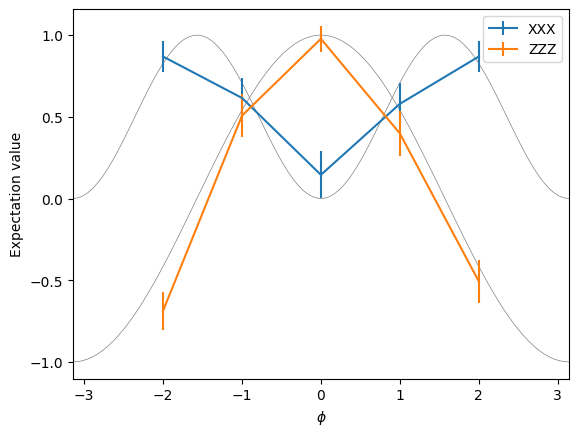

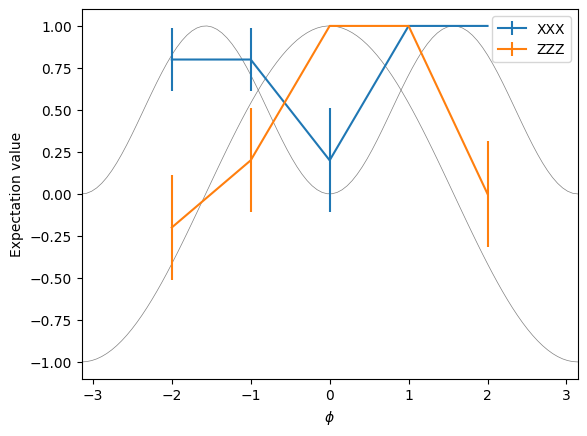

In [ ]:
n_shots = 10
sparse_param_sweep=np.array((-2,-1,0,1,2))
which="load"

if which == "run":
    real_result=backend_sample(real_backend,circuit,observables=observables,param_sweep=sparse_param_sweep,n_shots=n_shots)
elif which == "load":
    job_key='crx14dshazpg0084b9xg'
    job = service.job(job_key)
    real_result = job.result()[0]


# plot hardware results
plot_estimator_result(
    result=real_result, 
    param_sweep=sparse_param_sweep, 
    observables=observables,
    overlay_param_sweep=fine_param_sweep,
    overlay_result=ideal_result
    )


# simulate hardware results
n_shots = 10
fake_mimic_result = backend_sample(
    backend=fake_backend, 
    circuit=circuit, 
    observables=observables, 
    param_sweep=sparse_param_sweep,
    n_shots=n_shots
)

# plot simulated hardware results
plot_estimator_result(
    result=fake_mimic_result, 
    param_sweep=sparse_param_sweep, 
    observables=observables,
    overlay_param_sweep=fine_param_sweep,
    overlay_result=ideal_result
    )